No impact within tmax. Increase tmax or adjust v0/theta/D.


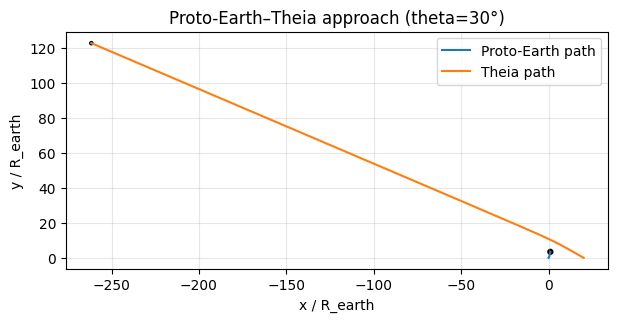

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Proto-Earth + Theia 2D impact (set approach angle theta)
# ----------------------------

# Physical-ish constants (you can change)
G = 6.67430e-11

M_earth = 5.972e24      # kg
R_earth = 6.371e6       # m

M_theia = 0.1 * M_earth # kg (roughly Mars-ish)
R_theia = 0.5 * R_earth # m (toy)

# Initial geometry + approach
D = 20 * R_earth        # initial separation (center-to-center), m
theta_deg = 30          # <-- CHANGE THIS: approach angle (0 = head-on)
v0 = 10_000             # m/s initial speed of Theia

dt = 1.0                # seconds
tmax = 200_000          # seconds (stop earlier on impact)

theta = np.deg2rad(theta_deg)

# Earth at origin (can also let both move; we DO let both move by default)
r1 = np.array([0.0, 0.0])      # Earth position
r2 = np.array([D, 0.0])        # Theia starts on +x

# Theia velocity points roughly toward Earth but tilted by theta
# Direction toward origin is (-1,0). Tilt "up" by theta:
v2 = v0 * np.array([-np.cos(theta), np.sin(theta)])

# Start Earth at rest (you can set Earth recoil by momentum conservation if desired)
v1 = np.array([0.0, 0.0])

def accel(r_self, r_other, m_other):
    r = r_other - r_self
    dist = np.linalg.norm(r)
    return G * m_other * r / (dist**3 + 1e-30)

# Storage for trajectories
traj1, traj2 = [r1.copy()], [r2.copy()]

impact = False
impact_step = None

# Velocity-Verlet integration (stable for gravity)
for step in range(int(tmax/dt)):
    a1 = accel(r1, r2, M_theia)
    a2 = accel(r2, r1, M_earth)

    # update positions
    r1_new = r1 + v1*dt + 0.5*a1*dt*dt
    r2_new = r2 + v2*dt + 0.5*a2*dt*dt

    # new accelerations
    a1_new = accel(r1_new, r2_new, M_theia)
    a2_new = accel(r2_new, r1_new, M_earth)

    # update velocities
    v1_new = v1 + 0.5*(a1 + a1_new)*dt
    v2_new = v2 + 0.5*(a2 + a2_new)*dt

    r1, r2 = r1_new, r2_new
    v1, v2 = v1_new, v2_new

    traj1.append(r1.copy())
    traj2.append(r2.copy())

    # impact check
    if np.linalg.norm(r2 - r1) <= (R_earth + R_theia):
        impact = True
        impact_step = step
        break

traj1 = np.array(traj1)
traj2 = np.array(traj2)

# Compute impact angle at contact (angle between relative velocity and line-of-centers)
if impact:
    r = r2 - r1
    r_hat = r / (np.linalg.norm(r) + 1e-30)
    v_rel = v2 - v1
    v_hat = v_rel / (np.linalg.norm(v_rel) + 1e-30)

    # theta_contact = angle between -v (incoming direction) and r_hat
    # Use incoming direction = -v_hat
    cosang = np.clip(np.dot(-v_hat, r_hat), -1.0, 1.0)
    theta_contact = np.degrees(np.arccos(cosang))
    print(f"Impact occurred at step {impact_step}, time ~ {impact_step*dt:.1f} s")
    print(f"Impact angle at contact (deg): {theta_contact:.2f}")
else:
    print("No impact within tmax. Increase tmax or adjust v0/theta/D.")

# Plot trajectories + final positions
fig, ax = plt.subplots(figsize=(7,7))
ax.plot(traj1[:,0]/R_earth, traj1[:,1]/R_earth, label="Proto-Earth path")
ax.plot(traj2[:,0]/R_earth, traj2[:,1]/R_earth, label="Theia path")

# Draw bodies at final/impact positions
from matplotlib.patches import Circle
ax.add_patch(Circle((r1[0]/R_earth, r1[1]/R_earth), R_earth/R_earth, fill=False, lw=2))
ax.add_patch(Circle((r2[0]/R_earth, r2[1]/R_earth), R_theia/R_earth, fill=False, lw=2))

ax.set_aspect("equal", "box")
ax.set_xlabel("x / R_earth")
ax.set_ylabel("y / R_earth")
ax.set_title(f"Proto-Earth–Theia approach (theta={theta_deg}°)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()
